In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### Load Libraries

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error

from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
PROCESSED_DATA_PATH = os.path.join("../", "../", "data_processed", "resale_flat_prices")
SEED = 42

### Load Data

In [4]:
df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, "engineered_data.csv"))

print(df.shape, '\n', df.columns)
display(df.head(3))

(865827, 29) 
 Index(['id', 'town', 'flat_type', 'flat_model', 'sale_date', 'floor', 'age',
       'relative_tenure', 'floor_area', 'psm', 'address', 'latitude',
       'longitude', 'latitude_rad', 'longitude_rad', 'nearest_atm',
       'nearest_libraries', 'nearest_hawkers', 'nearest_stores',
       'nearest_post_offices', 'nearest_bus_stops', 'nearest_pharmacies',
       'nearest_primary_schools', 'nearest_parks', 'nearest_trains',
       'sale_month', 'cpi', 'cpi_psm', 'avg_sora'],
      dtype='object')


,id,town,flat_type,flat_model,sale_date,floor,age,relative_tenure,floor_area,psm,...,nearest_post_offices,nearest_bus_stops,nearest_pharmacies,nearest_primary_schools,nearest_parks,nearest_trains,sale_month,cpi,cpi_psm,avg_sora
0,1,JURONG_WEST,3_ROOM,IMPROVED,1990-01-01,5.0,16,0.899953,70.0,334.285714,...,0.798752,0.195397,0.761661,0.541789,0.947906,0.904104,1,61.9,595.125779,NaN
1,2,OTHER,5_ROOM,STANDARD,1990-01-01,5.0,15,0.902280,120.0,916.666667,...,3.042559,0.090376,1.133326,0.159056,0.330270,1.954674,1,61.9,1631.933226,NaN
2,3,BUKIT_MERAH,3_ROOM,IMPROVED,1990-01-01,5.0,15,0.902280,63.0,722.222222,...,1.148847,0.446105,0.850333,0.943485,0.737703,0.932695,1,61.9,1285.765572,NaN


In [5]:
df["is_imputted_sora"] = np.where(df["avg_sora"].isnull(), 1, 0)

imp = SimpleImputer()
df["avg_sora"] = imp.fit_transform(df["avg_sora"].to_numpy().reshape(-1, 1))

df.drop(columns=["id", "sale_date", "address", "latitude_rad", "longitude_rad", "latitude", "longitude", "psm"], inplace=True)

df = pd.get_dummies(df, columns=["flat_type", "flat_model", "town"], dummy_na = True, dtype=np.uint8)
df.drop(columns=["town_nan", "flat_type_nan", "flat_model_nan"], inplace=True)

print(df.shape, '\n', df.columns)
display(df.head(3))

(865827, 58) 
 Index(['floor', 'age', 'relative_tenure', 'floor_area', 'nearest_atm',
       'nearest_libraries', 'nearest_hawkers', 'nearest_stores',
       'nearest_post_offices', 'nearest_bus_stops', 'nearest_pharmacies',
       'nearest_primary_schools', 'nearest_parks', 'nearest_trains',
       'sale_month', 'cpi', 'cpi_psm', 'avg_sora', 'is_imputted_sora',
       'flat_type_3_ROOM', 'flat_type_4_ROOM', 'flat_type_5_ROOM',
       'flat_type_EXECUTIVE', 'flat_type_OTHER', 'flat_model_APARTMENT',
       'flat_model_IMPROVED', 'flat_model_MAISONETTE', 'flat_model_MODEL_A',
       'flat_model_MODEL_A2', 'flat_model_NEW_GENERATION', 'flat_model_OTHER',
       'flat_model_PREMIUM_APARTMENT', 'flat_model_SIMPLIFIED',
       'flat_model_STANDARD', 'town_ANG_MO_KIO', 'town_BEDOK', 'town_BISHAN',
       'town_BUKIT_BATOK', 'town_BUKIT_MERAH', 'town_BUKIT_PANJANG',
       'town_CHOA_CHU_KANG', 'town_CLEMENTI', 'town_GEYLANG', 'town_HOUGANG',
       'town_JURONG_EAST', 'town_JURONG_WEST', 'to

,floor,age,relative_tenure,floor_area,nearest_atm,nearest_libraries,nearest_hawkers,nearest_stores,nearest_post_offices,nearest_bus_stops,...,town_PASIR_RIS,town_PUNGGOL,town_QUEENSTOWN,town_SEMBAWANG,town_SENGKANG,town_SERANGOON,town_TAMPINES,town_TOA_PAYOH,town_WOODLANDS,town_YISHUN
0,5.0,16,0.899953,70.0,0.521140,0.751719,0.576328,0.521140,0.798752,0.195397,...,0,0,0,0,0,0,0,0,0,0
1,5.0,15,0.902280,120.0,0.391706,0.930882,0.290215,0.368291,3.042559,0.090376,...,0,0,0,0,0,0,0,0,0,0
2,5.0,15,0.902280,63.0,0.165177,1.399324,0.165177,0.047929,1.148847,0.446105,...,0,0,0,0,0,0,0,0,0,0


### Instantiate Best XGBoost Model

In [6]:
model = XGBRegressor(random_state=SEED)
model

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)

### Fit & Score

In [7]:
X, y = df.drop('cpi_psm', axis=1), df.cpi_psm

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state = SEED)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(779244, 57) (779244,)
(86583, 57) (86583,)


In [8]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [9]:
model.score(X_test, y_test)

0.953989681534846

In [10]:
pickle.dump(model, open('xgboost_best_model_v1.pkl', 'wb'))

### Evaluation

In [11]:
def produce_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rtwo = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mdape = median_absolute_error(y_test, y_pred)/np.median(y_test)
    return mse, mse**(0.5), mae, rtwo, mape, mdape

In [12]:
y_pred = model.predict(X_test)

mse, rmse, mae, rtwo, mape, mdape = produce_metrics(y_test, y_pred)
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {rtwo}")
print(f"MAPE: {mape}")
print(f"MdAPE: {mdape}")

MSE: 85318.35250797549
RMSE: 292.0930545356659
MAE: 216.68177571921927
R2: 0.953989681534846
MAPE: 0.05771889484352634
MdAPE: 0.0413310392059578


### Actual vs Pred

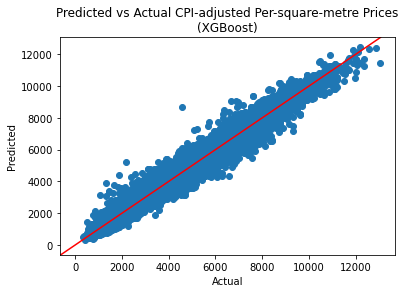

In [13]:
fig, ax = plt.subplots()
ax.axline((0, 0), slope=1, color="red")
plt.scatter(y_test, y_pred)
plt.title("Predicted vs Actual CPI-adjusted Per-square-metre Prices\n(XGBoost)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()